# Fourth Experiment

Driver:

    - cores: 1
    - coreLimit: "1200m"
    - memory: "2g"

Executor:

    - cores: 1
    - coreLimit: "2000m"
    - instances: 2
    - memory: "1500m"

Start 27-04-2025 18:00

Stop 27-04-2025 19:22

Commit 4611fbdb747d1d453882a8ddc5204f4af087a047

`"max.in.flight.requests.per.connection": 1`

In [1]:
import sys
from pathlib import Path

import pandas as pd

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

from charts import (
    latency_box_plot,
    latency_distribution_plot,
    latency_line_plot,
)
from functions import calculate_latencies
from utils import fix_timestamps_timezone

experiment_name = "fourth_experiment"

df_cloud = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-04-27-19_35_23-avro-cloud.parquet")
df_cloud = df_cloud.sort_values("source_timestamp")
df_edge = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-04-27-19_38_10-avro-edge.parquet")
df_edge = df_edge.sort_values("source_timestamp")

In [2]:
df_cloud = fix_timestamps_timezone(df_cloud)
df_edge = fix_timestamps_timezone(df_edge)

In [3]:
df_cloud = calculate_latencies(df_cloud)
df_edge = calculate_latencies(df_edge)

In [6]:
start_time = pd.Timestamp("2025-04-27 18:00:00", tz="UTC")
end_time = pd.Timestamp("2025-04-27 19:22:00", tz="UTC")

df_cloud_filtered = df_cloud[
    (df_cloud["source_timestamp"] >= start_time) &
    (df_cloud["source_timestamp"] <= end_time)
]

df_edge_filtered = df_edge[
    (df_edge["source_timestamp"] >= start_time) &
    (df_edge["source_timestamp"] <= end_time)
]

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1098: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


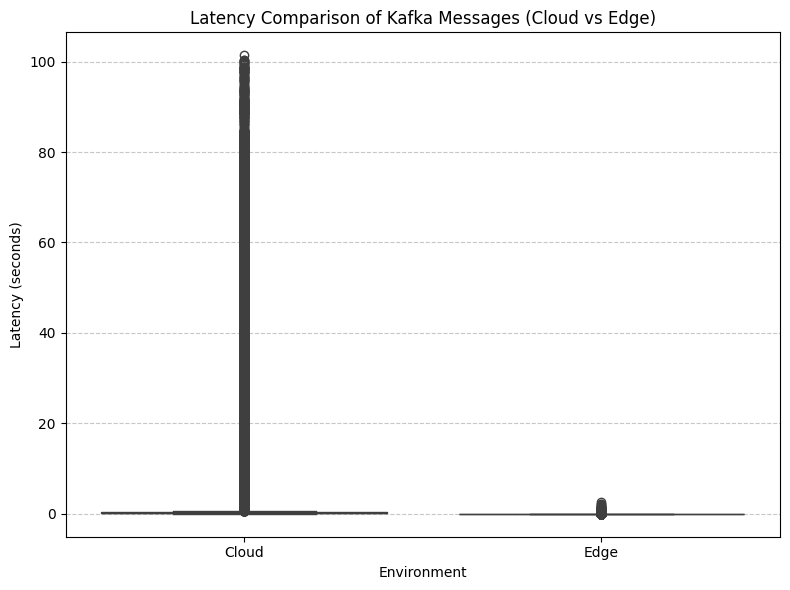

In [7]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="source_kafka_latency")

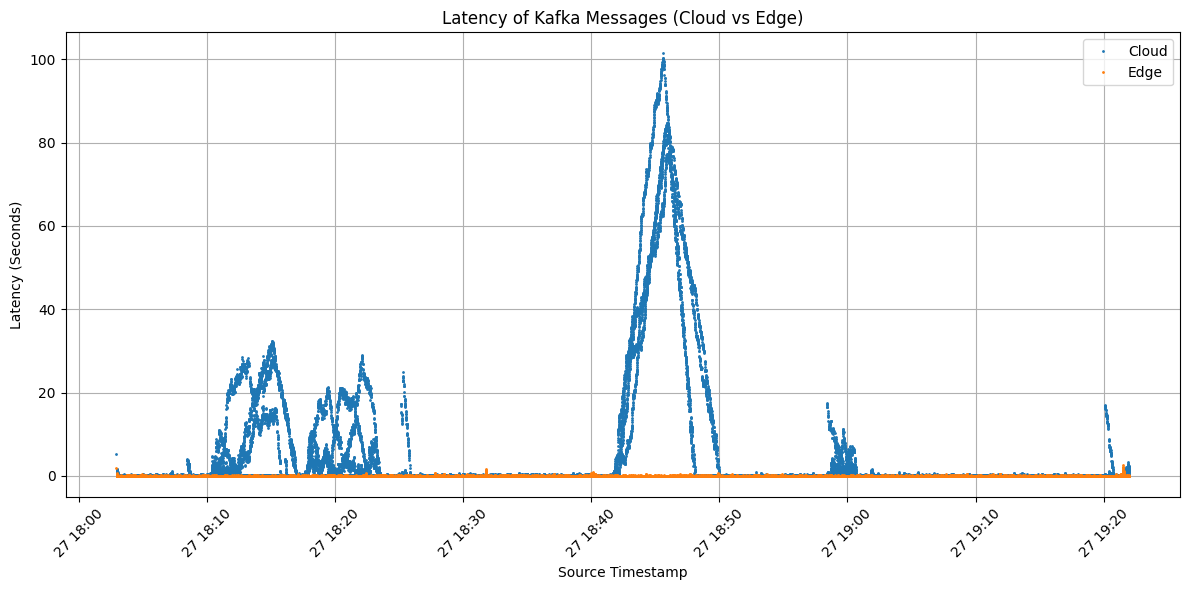

In [8]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x="source_timestamp", y="source_kafka_latency")

📊 Statistics:
                 mean    median        std
Environment                               
Cloud        5.339401  0.121608  14.812247
Edge         0.029332  0.025993   0.042109


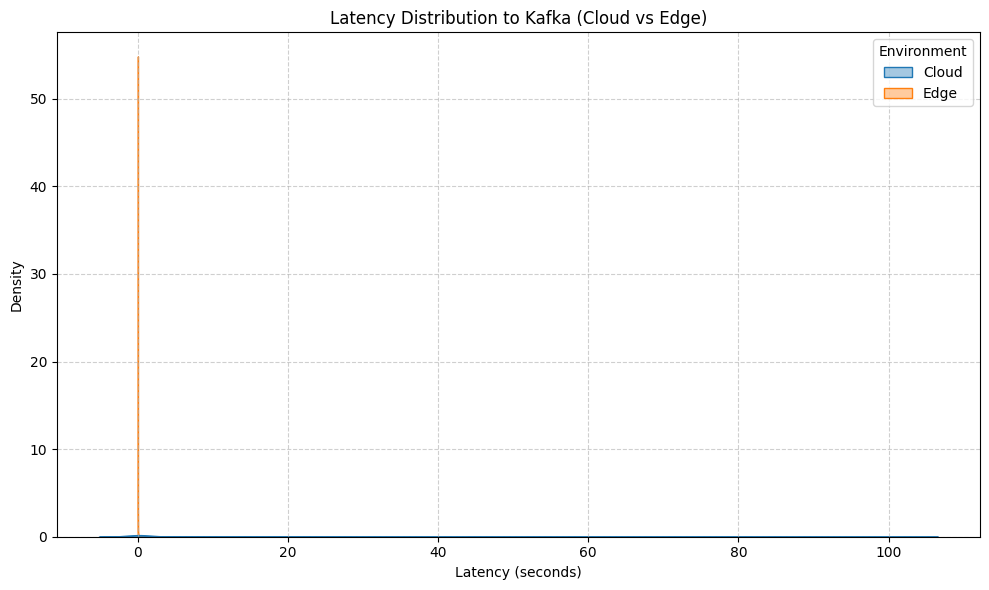

In [9]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="source_kafka_latency")

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1098: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


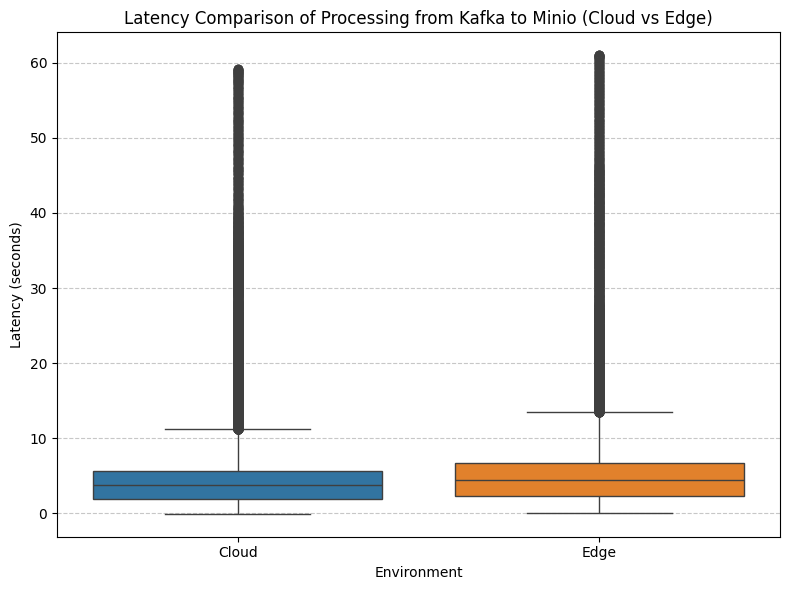

In [10]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="kafka_landing_latency", title="Latency Comparison of Processing from Kafka to Minio (Cloud vs Edge)")

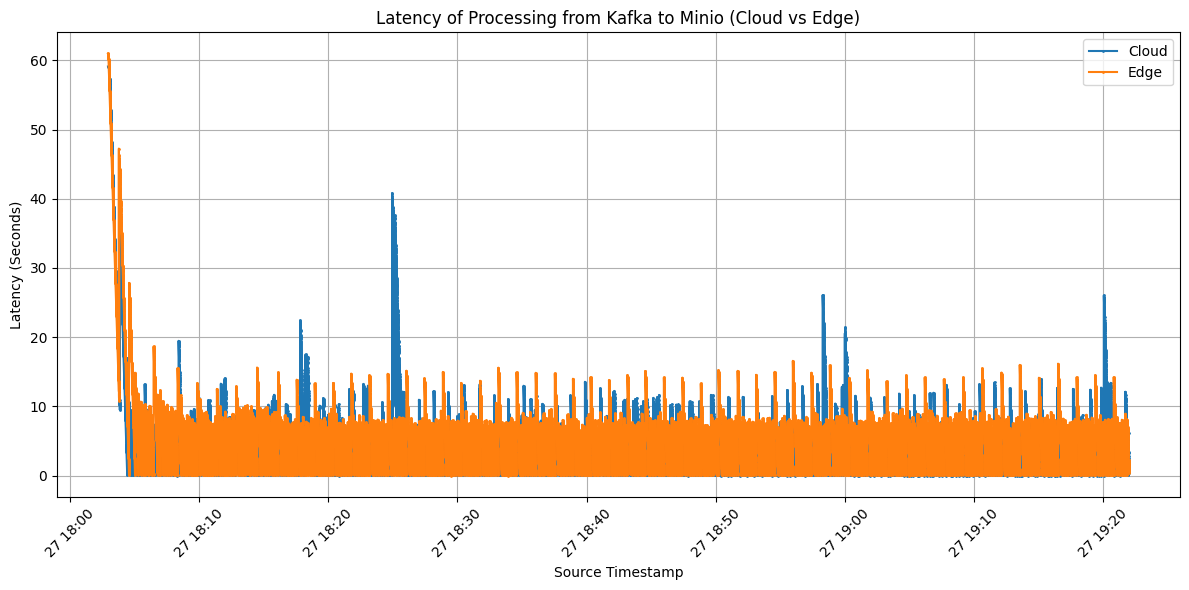

In [11]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x='source_timestamp', y='kafka_landing_latency', title='Latency of Processing from Kafka to Minio (Cloud vs Edge)', linestyle="solid")

📊 Statistics:
                 mean  median       std
Environment                            
Cloud        4.640977   3.740  5.243736
Edge         5.237168   4.501  5.287284


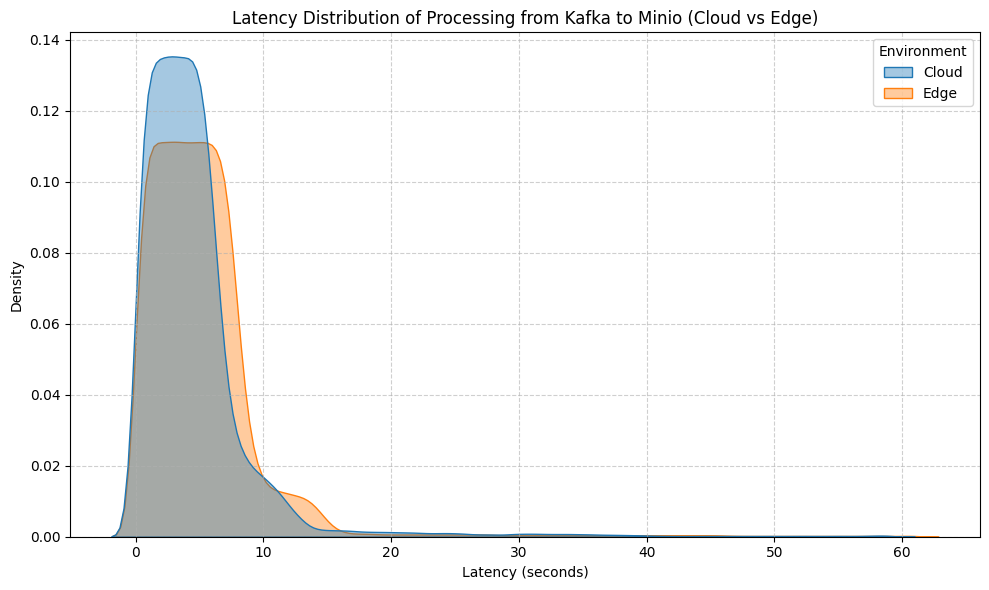

In [12]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="kafka_landing_latency", title="Latency Distribution of Processing from Kafka to Minio (Cloud vs Edge)")